In [1]:
import cv2
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from skimage.feature import hog
import glob
%matplotlib inline

cars = []
noncars = []
car_images = glob.glob('vehicles/*/*/*.png')
noncar_images = glob.glob('non-vehicles/*/*/*.png')
for img in car_images:
    cars.append(img)
for img in noncar_images:
    noncars.append(img)
    
print(len(cars))
print(len(noncars))

8792
8968


In [4]:
from sklearn.preprocessing import StandardScaler
t = time.time()
car_feature_list = extract_features(cars, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL')

noncar_feature_list = extract_features(noncars, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
print("extract feature time cost: ",time.time()-t)

extract feature time cost:  88.60268759727478


In [5]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
# Create an array stack, NOTE: StandardScaler() expects np.float64
X = np.vstack((car_feature_list,noncar_feature_list)).astype(np.float64)
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
#print(X_scaler)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_feature_list)), np.zeros(len(noncar_feature_list)))) # Define the labels vector

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)



(17760, 8460)


In [8]:
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5]}
svc = svm.SVC(probability=True)
svc.fit(X_train, y_train)
#svc = LinearSVC() # Use a linear SVC 
#svc.fit(X_train, y_train) # Train the classifier
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

Test Accuracy of SVC =  0.9949


In [9]:
import pickle


filename = 'finalized_model.sav'
pickle.dump(svc, open(filename, 'wb'))
pickle.dump(X_scaler, open('xscaler.pkl','wb')) 
# some time later...
 
# load the model from disk

#svc = pickle.load(open(filename, 'rb'))


In [1]:
import pickle
from sklearn.preprocessing import StandardScaler
import cv2
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from skimage.feature import hog
import glob
%matplotlib inline

filename = 'finalized_model.sav'
svc = pickle.load(open(filename, 'rb'))
X_scaler = pickle.load(open('xscaler.pkl','rb'))

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
         # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #print(max(spatial_features))
        #print(max(hist_features))
        #print(max(hog_features))
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

def extract_flip_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.flip(image,1)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
         # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #print(max(spatial_features))
        #print(max(hist_features))
        #print(max(hog_features))
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [3]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, xstart,xstop,scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    boxes = []
    scores = []
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            #print(subimg.shape)
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #print(spatial_features.shape, hist_features.shape, hog_features.shape)
            
            #X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1).astype(np.float64)
            #X_scaler = StandardScaler().fit(X)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict_proba(test_features)[0][1]
            #print(test_prediction)
            #print(svc.predict_proba(test_features))
            if test_prediction >=0.5:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                top_left_draw = (int(xbox_left), int(ytop_draw+ystart))
                bot_right_draw = (int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))
                boxes.append((top_left_draw, bot_right_draw))
                scores.append(test_prediction)
    return boxes,scores
    

    
#out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


In [5]:
def find_windows(img, ystart, ystop, xstart,xstop,scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    boxes = []
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image

    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            
            xbox_left = np.int(xleft*scale)+xstart
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            top_left_draw = (int(xbox_left), int(ytop_draw+ystart))
            bot_right_draw = (int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))
            boxes.append((top_left_draw, bot_right_draw))
    return boxes
    

    
#out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

In [6]:
class Heatmap():
    def __init__(self):
        self.heatmaps = []
        self.heatmap_sum = None
        

In [7]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    #global preheatmap
    #heatmap +=preheatmap
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    #global preheatmap
    heatmap[heatmap <= threshold] = 0
    #heatmap[heatmap > threshold] = 1
    #preheatmap = heatmap
    # Return thresholded map
    return heatmap




import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #if abs(np.subtract(bbox[0],bbox[1])[0]*np.subtract(bbox[0],bbox[1])[1])>128:
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img





In [38]:
def pipeline(img):
   
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bboxes = []
    pickboxes = []
    pickscores = []
    #bboxes = find_cars(img, 400, 550, 700, 950, 1.3, svc, 9, 8, 2, (32,32), 32)
    bboxes,scores = find_cars(img, 400, 656, 800, 1280,1.5, svc, 9, 8, 2, (32,32), 32)
    #bboxes += find_cars(img, 400, 600, 800, 1100, 1.7,svc, 9, 8, 2, (32,32), 32)
    #bboxes += find_cars(img, 400, 700, 800,1280,2.0, svc, 9, 8, 2, (32,32), 32)[0]
    #scores += find_cars(img, 400, 700, 800,1280,2.0, svc, 9, 8, 2, (32,32), 32)[1]
    #bboxes += find_cars(img, 400, 720, 800,1280,2.5, svc, 9, 8, 2, (32,32), 32)
    if not bboxes:
        pickboxes = []
        pickscores = []
    else:
        pickboxes,pickscores = NMS(bboxes,scores,0.55)
    
    heatmap = np.zeros_like(img)
    heatmap = add_heat(heatmap, pickboxes)

    average_n = 10
    hm.heatmaps.append(heatmap)
    if len(hm.heatmaps)>average_n:
        hm.heatmaps = hm.heatmaps[-average_n:]
    hm.heatmap_sum = np.sum(hm.heatmaps,axis=0)
    hm.heatmap_sum[hm.heatmap_sum<=(0.5*len(hm.heatmaps))]=0
    #hm.heatmap_sum[hm.heatmap_sum<= 8]=0
    #heatmap = apply_threshold(heatmap, 3)
    labels = label(hm.heatmap_sum)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #draw_img = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
    return draw_img

In [9]:
def NMS(boxes,scores,overlap_threshold):
    areas = []
    pickboxes = []
    pickscores = []
    if len(boxes)==0:
        return None
    else:
        for box in boxes:
            x1 = box[0][0]
            y1 = box[0][1]
            x2 = box[1][0]
            y2 = box[1][1]
            area = (x1-x2+1)*(y1-y2+1)
            areas.append(area)
        
        idxes = np.argsort(np.array(scores))
        while len(idxes)>0:
            lastindex = len(idxes)-1
            last = idxes[lastindex]
            lastbox = boxes[last]
            pickboxes.append(lastbox)
            score = scores[last]
            pickscores.append(score)
            lastx1 = lastbox[0][0]
            lasty1 = lastbox[0][1]
            lastx2 = lastbox[1][0]
            lasty2 = lastbox[1][1]
            suppress = []
            suppress.append(lastindex)
            for index in range(lastindex):
                pos = idxes[index]
                curbox = boxes[pos]
                curx1 =curbox[0][0]
                cury1 =curbox[0][1]
                curx2 =curbox[1][0]
                cury2 =curbox[1][1]
                xx1 = max(lastx1,curx1)
                yy1 = max(lasty1,cury1)
                xx2 = min(lastx2,curx2)
                yy2 = min(lasty2,cury2)
                w = xx2-xx1+1
                h = yy2-yy1+1
                if w>0 and h>0:
                    sharearea = w*h/min(areas[last],areas[pos])
                    if sharearea > overlap_threshold:
                        suppress.append(index)
            idxes = np.delete(idxes, suppress)
        return pickboxes,pickscores
                    

In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#preheatmap = np.zeros_like(cv2.imread("test_images/test1.jpg"))
hm = Heatmap()
white_output = 'test_result.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4


 97%|████████████████████████████████████████▉ | 38/39 [02:55<00:04,  4.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

Wall time: 2min 56s


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#preheatmap = np.zeros_like(cv2.imread("test_images/test1.jpg"))
hm = Heatmap()
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  1%|▎                                       | 11/1261 [00:23<44:16,  2.13s/it]

In [46]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
num=0
def catch_img(img):
    global num
    saveimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite("project_images/frame%d.jpg" % num,saveimg)
    num=num+1
    return img
white_output = 'test.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(catch_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [01:20<00:00, 15.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 1min 13s, sys: 2.36 s, total: 1min 15s
Wall time: 1min 22s


2 cars found


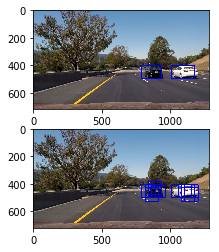

In [10]:
from scipy.ndimage.measurements import label

test_img = cv2.imread("test_images/test6.jpg") 
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
bboxes = []
scores = []
#bboxes = find_cars(test_img, 400, 550, 600, 950, 1.3, svc, 9, 8, 2, (32,32), 32)
bboxes,scores= find_cars(test_img, 380, 550, 600, 1280,1.5, svc, 9, 8, 2, (32,32), 32)
#bboxes += find_cars(test_img, 360, 600, 400, 1280, 1.7,svc, 9, 8, 2, (32,32), 32)
#bboxes += find_cars(test_img, 340, 700, 300,1280,2.0, svc, 9, 8, 2, (32,32), 32)
#bboxes += find_cars(test_img, 320, 720, 300,1280,2.5, svc, 9, 8, 2, (32,32), 32)

if not bboxes:
    pickboxes = []
else:
    pickboxes,pickscores = NMS(bboxes,scores,0.55)

heatmap = np.zeros_like(test_img)
heatmap = add_heat(heatmap, pickboxes)
heatmap = apply_threshold(heatmap, 0)
labels = label(heatmap)

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
print(labels[1], 'cars found')
# Display the image
#plt.imshow(draw_img)
result = draw_boxes(test_img, bboxes, color=(0, 0, 255), thick=6)
#plt.imshow(result)

plt.figure(1)
plt.subplot(211)
plt.imshow(draw_img)

plt.subplot(212)
plt.imshow(result)
plt.show()

156


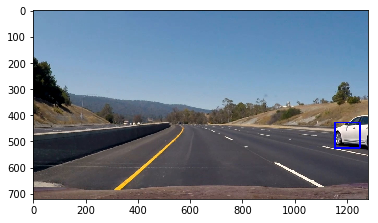

In [56]:
pickboxes = None
pickscores = None
num = 0
while pickboxes is None:
    test_img = cv2.imread("project_images/frame%d.jpg"%num) 
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    #bboxes = find_cars(test_img, 400, 550, 600, 950, 1.3, svc, 9, 8, 2, (32,32), 32)
    bboxes,scores= find_cars(test_img, 380, 550, 600, 1280,1.5, svc, 9, 8, 2, (32,32), 32)
    if not bboxes:
        num=num+1
    else:
        pickboxes,pickscores = NMS(bboxes,scores,0.55)
    
print(num)
#draw_img = draw_labeled_bboxes(np.copy(test_img), pickboxes)

result = draw_boxes(test_img, pickboxes, color=(0, 0, 255), thick=6)

plt.figure(1)

plt.imshow(result)
plt.show()

In [32]:
for box in bboxes:
    print(box)
    print(box[0][0])

((792, 404), (888, 500))
792
((816, 404), (912, 500))
816
((816, 428), (912, 524))
816
((840, 380), (936, 476))
840
((840, 404), (936, 500))
840
((864, 404), (960, 500))
864
((1008, 404), (1104, 500))
1008
((1056, 404), (1152, 500))
1056
((1080, 404), (1176, 500))
1080
((1080, 428), (1176, 524))
1080
((1104, 404), (1200, 500))
1104
((1104, 428), (1200, 524))
1104


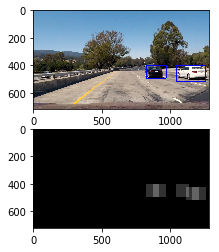

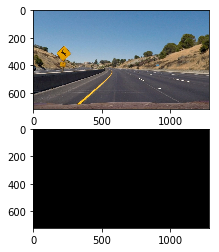

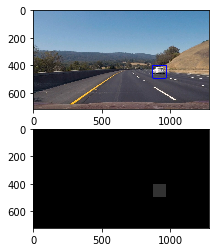

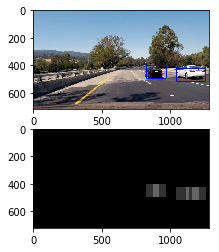

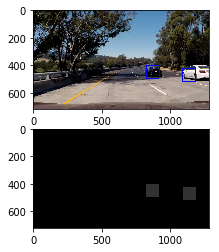

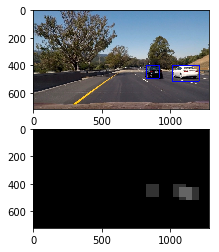

In [35]:
hm = Heatmap()
test_img1 = cv2.imread("test_images/test1.jpg")
test_img1 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB)
result1,heatmap1 = pipeline(test_img1)
test_img2 = cv2.imread("test_images/test2.jpg")
test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)
hm = Heatmap()
result2,heatmap2 = pipeline(test_img2)
test_img3 = cv2.imread("test_images/test3.jpg")
test_img3 = cv2.cvtColor(test_img3, cv2.COLOR_BGR2RGB)
hm = Heatmap()
result3,heatmap3 = pipeline(test_img3)
test_img4 = cv2.imread("test_images/test4.jpg")
test_img4 = cv2.cvtColor(test_img4, cv2.COLOR_BGR2RGB)
hm = Heatmap()
result4,heatmap4 = pipeline(test_img4)
test_img5 = cv2.imread("test_images/test5.jpg")
test_img5 = cv2.cvtColor(test_img5, cv2.COLOR_BGR2RGB)
hm = Heatmap()
result5,heatmap5 = pipeline(test_img5)
test_img6 = cv2.imread("test_images/test6.jpg")
test_img6 = cv2.cvtColor(test_img6, cv2.COLOR_BGR2RGB)
hm = Heatmap()
result6,heatmap6 = pipeline(test_img6)

plt.figure(1)
plt.subplot(211)
plt.imshow(result1)
plt.subplot(212)
plt.imshow(heatmap1)

plt.figure(2)
plt.subplot(211)
plt.imshow(result2)
plt.subplot(212)
plt.imshow(heatmap2)

plt.figure(3)
plt.subplot(211)
plt.imshow(result3)
plt.subplot(212)
plt.imshow(heatmap3)

plt.figure(4)
plt.subplot(211)
plt.imshow(result4)
plt.subplot(212)
plt.imshow(heatmap4)

plt.figure(5)
plt.subplot(211)
plt.imshow(result5)
plt.subplot(212)
plt.imshow(heatmap5)

plt.figure(6)
plt.subplot(211)
plt.imshow(result6)
plt.subplot(212)
plt.imshow(heatmap6)

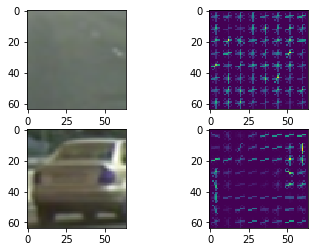

In [37]:
img = cv2.imread("non-vehicles/non-vehicles/GTI/image1.png")
img2 = cv2.imread("vehicles/vehicles/GTI_Left/image0009.png")
aimg = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
aimg2 = cv2.cvtColor(img2, cv2.COLOR_BGR2YCrCb)
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 9

features, hog_image = hog(aimg[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features2, hog_image2 = hog(aimg2[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
plt.figure(1)
plt.subplot(221)
plt.imshow(img)

plt.subplot(222)
plt.imshow(hog_image)

plt.subplot(223)
plt.imshow(img2)

plt.subplot(224)
plt.imshow(hog_image2)
plt.show()